<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.855 · Modelos avanzados de minería de datos · PEC2</p>
<p style="margin: 0; text-align:right;">2021-1 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 2: Métodos no supervisados

A lo largo de esta práctica veremos como aplicar distintas técnicas no supervisadas
así como algunas de sus aplicaciones reales:

 - **[Clustering con distintas estrategias](#ej1)**: k-means y regla del codo, basadas en densidad y jerárquicas.
 - **[Aplicación: generación de imágenes con reducción de dimensionalidad](#ej2)**. PCA y UMAP.
 - **[Aplicación: identificación de puntos de interés turísticos](#ej3)**.

<div class="alert alert-block alert-info">
<strong>Nombre y apellidos: Mario Ubierna San Mamés</strong>
</div>

---

Para ello vamos a necesitar las siguientes librerías:

In [1]:
import random

import umap
import numpy as np
import pandas as pd
import sklearn
from sklearn import cluster        # Algoritmos de clustering.
from sklearn import datasets       # Crear datasets.
from sklearn import decomposition  # Algoritmos de reduccion de dimensionalidad.

# Visualizacion.
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

<a id="ej1"></a>

## 1. Métodos de *clustering* (4 puntos)

Este ejercicio trata de explorar distintas técnicas de agrupamiento ajustándolas a distintos conjuntos de datos.

El objetivo es doble: entender la influencia de los parámetros en su comportamiento, y conocer sus limitaciones en la búsqueda de estructuras de datos.

### Generación de los conjuntos de datos

In [2]:
X_blobs, y_blobs = datasets.make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=1.6, random_state=42)
X_moons, y_moons = datasets.make_moons(n_samples=1000, noise=.07, random_state=42)
X_circles, y_circles = datasets.make_circles(n_samples=1000, factor=.5, noise=.05, random_state=42)

Cada dataset tiene 2 variables: una variable *X* que contiene 2 features (columnas) y tantas filas como muestras. Y una variable *y* que alberga las etiquetas que identifican cada cluster.

A lo largo del ejercicio no se usará la variable *y* (sólo con el objetivo de visualizar). El objetivo es a través de los distintos modelos de *clustering* conseguir encontrar las estructuras descritas por las variables *y*.

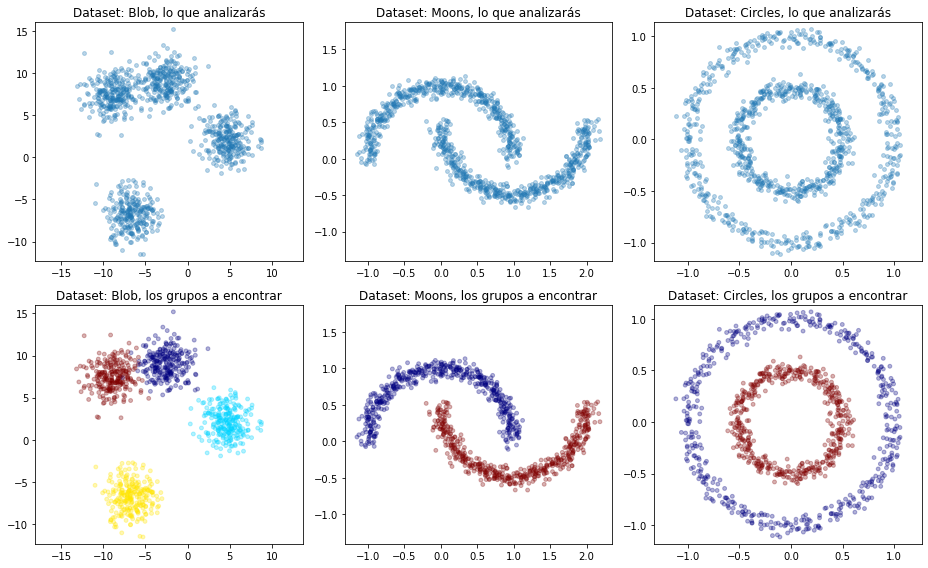

In [3]:
# NO ME FUNCIONA EN LOCAL (muere el kernel), SÍ EN GOOGLE COLAB
fig, axis = plt.subplots(2, 3, figsize=(13, 8))
for i, (X, y, ax, name) in enumerate(zip([X_blobs, X_moons, X_circles] * 2,
                                         [None] * 3 + [y_blobs, y_moons, y_circles],
                                         axis.reshape(-1),
                                         ['Blob', 'Moons', 'Circles'] * 2)):
    ax.set_title('Dataset: {}, '.format(name) + ('lo que analizarás' if i < 3 else 'los grupos a encontrar'))
    ax.scatter(X[:,0], X[:,1], s=15, c=y, alpha=.3, cmap='jet')
    ax.axis('equal')
plt.tight_layout()

### 1 a. K-means

En este apartado se pide probar el algoritmo *k-means* sobre los tres datasets presentados anteriormente ajustando con los parámetros adecuados y analizar sus resultados.

In [4]:
X, y = X_blobs, y_blobs

Para estimar el número de clusters a detectar por *k-means*. Una técnica para estimar $k$ es, como se explica en la teoría:
> Los criterios anteriores (minimización de distancias intra grupo o maximización de distancias inter grupo) pueden usarse para establecer un valor adecuado para el parámetro k. Valores k para los que ya no se consiguen mejoras significativas en la homogeneidad interna de los segmentos o la heterogeneidad entre segmentos distintos, deberían descartarse.

Lo que popularmente se conocer como *regla del codo*.

Primero es necesario calcular la suma de los errores cuadráticos ([*SSE*](https://bl.ocks.org/rpgove/0060ff3b656618e9136b)) que consiste en la suma de todos los errores (distancia de cada punto a su centroide asignado) al cuadrado.

$$SSE = \sum_{i=1}^{K} \sum_{x \in C_i} euclidean(x, c_i)^2$$

Donde $K$ es el número de clusters a buscar por *k-means*, $x \in C_i$ son los puntos que pertenecen a i-ésimo cluster, $c_i$ es el centroide del cluster $C_i$ (al que pertenece el punto $x$), y $euclidean$ es la [distancia euclídea](https://en.wikipedia.org/wiki/Euclidean_distance).

Este procedimiento realizado para cada posible valor $k$, resulta en una función monótona decreciente, donde el eje $x$ representa los distintos valores de $k$, y el eje $y$ el $SSE$. Intuitivamente se podrá observar un significativo descenso del error, que indicará el valor idóneo de $k$.

**Se pide realizar la representación gráfica de la regla del codo junto a su interpretación, utilizando la librería ```matplotlib``` y la implementación en scikit-learn de [*k-means*](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).**

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Blobs.
</div>

C:\Users\mario\anaconda3\envs\uoc20211pec1\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


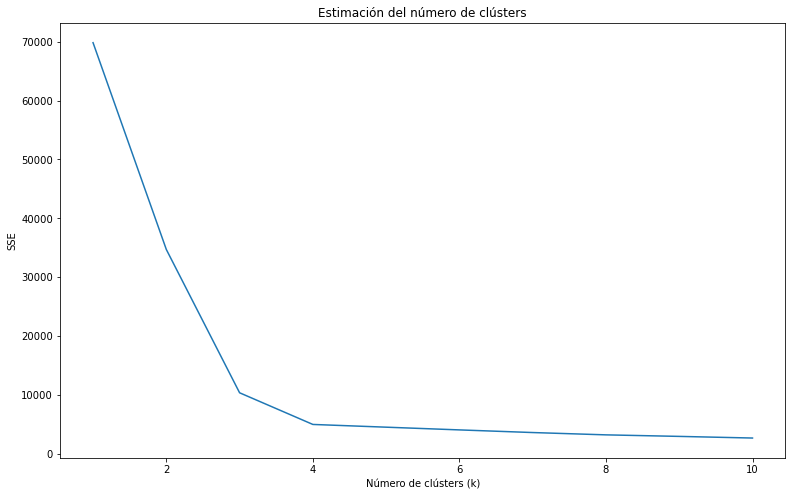

In [5]:
def sse_kmeans(X, k): 
    sse = []
    for i in range(1, k):
        kmeans = cluster.KMeans(n_clusters=i)
        kmeans.fit(X)
        sse.append(kmeans.inertia_)
    return sse

def elbow_kmeans(sse, k):
    fig, ax = plt.subplots(figsize=(13, 8))
    ax.plot(range(1, k), sse)
    plt.title("Estimación del número de clústers")
    plt.xlabel("Número de clústers (k)")
    plt.ylabel("SSE")
    plt.show()

# Cálculo
k = 11
sse = sse_kmeans(X, k)

# Visualación
elbow_kmeans(sse, k)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica? ¿Cómo podría mejorarse la elección de $k$?.  
</div>

De la gráfica anterior podemos interpretar lo siguiente:

- El número de clústers óptimo para este dataset es de 4, es decir, elegimos como número de clústers (k) donde se produce el "codo" en la función, esto quiere decir donde la suma de los errores cuadráticos se atenúa (donde la distancia de cada punto a su centroide es menor).

Cabe destacar, que se podría elegir 3 clústers, pero este valor no sería el óptimo ya que la suma de los errores cuadráticos es mayor.

El SSE (suma de los errores cuadráticos), calcula la distancia de cada punto a su centroide, por lo que busca minimizar dicha distancia, es decir, que los clústers sean lo más compactos posibles. Otra forma de mejorar la elección de k es medir la distancia entre centroides, cuanto más distancia haya entre centroides más diferentes van a ser los clústers.

Por lo tanto, se podría hacer el cálculo de maximizar la distancia entre centroides para también mejorar la elección de k, en este caso porque en la anterior ejecución queda claro que lo mejor son 4 clústers, pero hacer este cálculo podría ayudarnos a si es mejor 3 o 5 clústers por ejemplo.


<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Blobs.
</div>

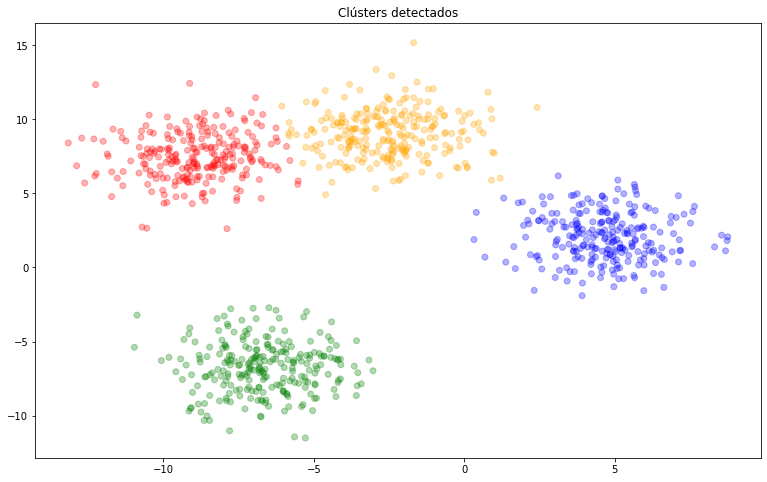

In [6]:
def clusters_view(X, labels):
    fig, ax = plt.subplots(figsize=(13, 8))
    plt.title("Clústers detectados")
    
    colores = ["blue", "red", "green", "orange", "black", "grey"]
    labels_color = []
    for i in labels:
        labels_color.append(colores[i])
    ax.scatter(X[:,0], X[:,1], c=labels_color, alpha=.3)

# Cálculo
modelo_kmeans_blobs = cluster.KMeans(n_clusters=4, random_state=0)
modelo_kmeans_blobs.fit(X)

# Visualización
clusters_view(X, modelo_kmeans_blobs.labels_)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

Como resultado de la anterior ejecución, podemos ver que tenemos 4 grupos tal y como era de esperar, ya que al inicializar kmeans el valor de k era 4.

Mencionar que los grupos obtenidos son correctos, es decir, tenemos 4 colores (4 grupos) y los puntos de un mismo color están más próximos al centro del clúster del mismo color que al centro de los otros grupos.

El resultado al ejecutar kmeans nos generá los siguientes grupos:
- Grupo arriba a la izquierda: se caracteriza porque el valor de la primera columna del dataset es pequeño, y el valor de la segunda columna es elevado.
- Grupo arriba a la derecha: se caracteriza porque el valor de la primera columna es medio y el de la segunda columna es elevado.
- Grupo abajo a la izquierda: tanto la primera columna como la segunda tienen valores pequeños.
- Grupo abajo a la derecha: en la primera columna tienen un elevado valor, mientras que en la segunda tienen un valor medio

In [7]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Moons.
</div>

C:\Users\mario\anaconda3\envs\uoc20211pec1\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


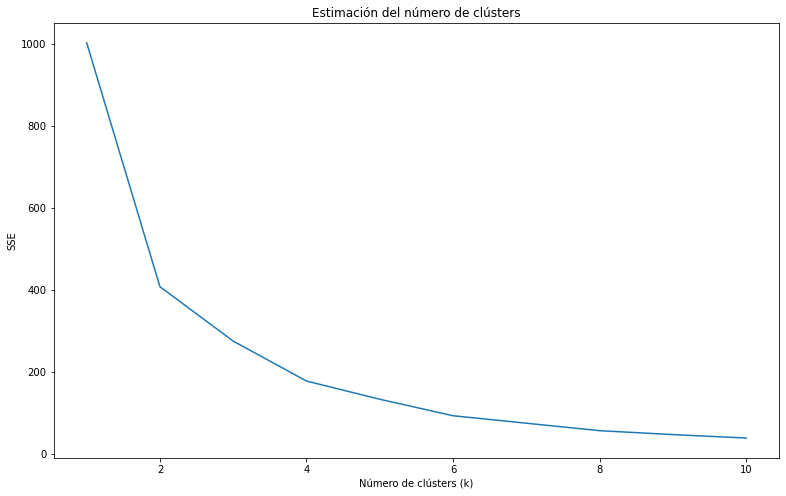

In [8]:
# Cálculo
k = 11
sse = sse_kmeans(X, k)

# Visualación
elbow_kmeans(sse, k)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica? ¿Cómo podría mejorarse la elección de $k$?.  
</div>

Según la interpretación de la gráfica el valor óptimo del número de clústers podría ser 4 o 5, en nuestro caso vamos a elegir 4 ya que éste minimiza el error cuadrático de los residuos y generaliza algo más, por lo que a priori esta es la mejor opción.

Al igual que sucedía en el ejercicio anterior, podríamos mejorar la elección de k si calculásemos también la distancia entre los centroides, de tal forma que fuera la máxima, así se conseguría tener clústers bien diferentes unos de los otros a parte de ser homogéneos.

También se podría mejorar la elección de k probando diferentes modelos con diferentes k, en este caso no se sabe a priori si un modelo con 4 grupos es mejor que 5, por lo que se puede generar diferentes modelos y ver los resultado que proporciona.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Moons.
</div>

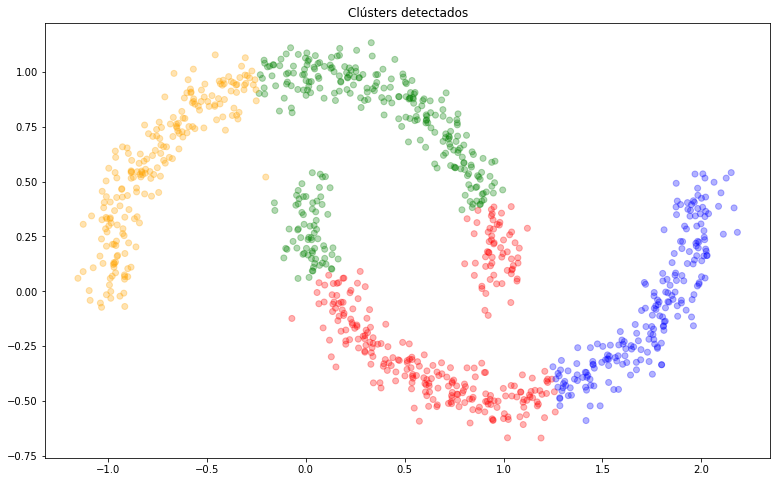

In [9]:
# Cálculo
modelo_kmeans_moons = cluster.KMeans(n_clusters=4, random_state=0)
modelo_kmeans_moons.fit(X)

# Visualización
clusters_view(X, modelo_kmeans_moons.labels_)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

En este caso, vemos que el modelo generado no es bueno, es decir, no consigue clasificar bien las instancias del dataset. Esto se debe principalmente a que el dataset es muy variado. 

Aún así vemos que realmente sí que hay grupos, para ser más exactos hay dos, dos medias lunas, pero kmeans no es capaz de detectar bien los grupos básicamente porque el problema ha cambiado, los centroides de cada clúster no están claros, aunque sabemos que hay dos clústers, en resumen es un problema de densidad no de distancia. Kmeans no es capaz de elegir dos buenos centroides porque presupone que los clústers tienen forma convexa, no funciona bien si los clústers son no convexos, es decir, calcula los clústers a partir de la distancia no de la densidad.

In [10]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Circles.
</div>

C:\Users\mario\anaconda3\envs\uoc20211pec1\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


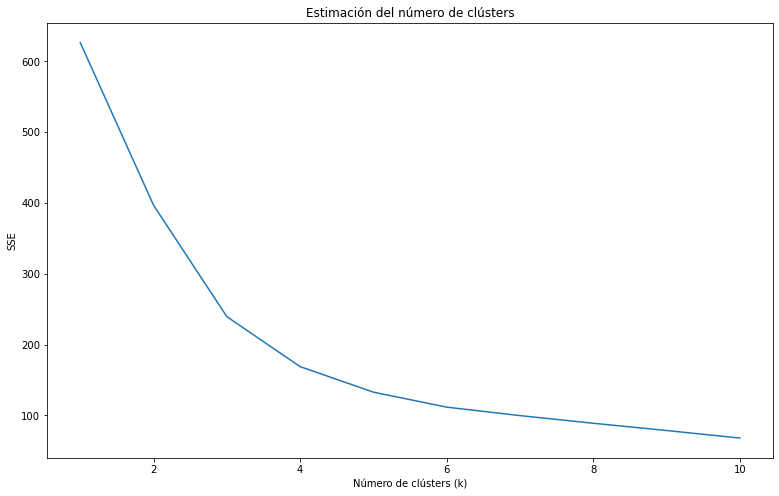

In [11]:
# Cálculo
k = 11
sse = sse_kmeans(X, k)

# Visualación
elbow_kmeans(sse, k)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica? ¿Cómo podría mejorarse la elección de $k$?.  
</div>

De la gráfica anterior podemos concluir que el mejor número de clústers puede ser 4 o 5, ya que es en estos puntos donde se reduce más el error cuadrático de los residuos y así vez conseguimos generalizar. En nuestro caso, se ha decidido elegir un valor de k igual a 4, ya que conseguimos reducir el error y generalizar más.

Al igual que en los apartados anteriores, podemos mejorar la elección de k a partir de maximizar la distancia entre los centroides de cada grupo, o también ejecutando varios modelos y ver cuál nos produce un resultado mejor.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Circles.
</div>

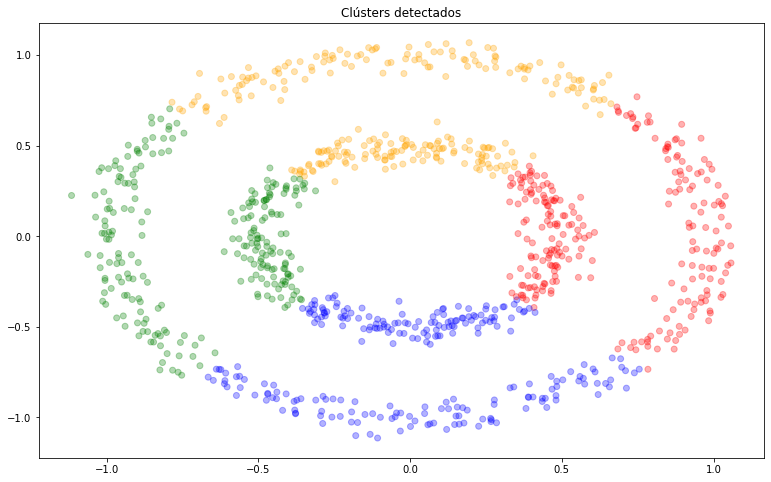

In [12]:
# Cálculo
modelo_kmeans_circles = cluster.KMeans(n_clusters=4, random_state=0)
modelo_kmeans_circles.fit(X)

# Visualización
clusters_view(X, modelo_kmeans_circles.labels_)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

En este caso pasa lo mismo que en el ejericio anterior, kmeans calcula los clústers a partir de la distancia de cada punto al centroide y no por densidad, por lo que no es capaz de distinguir bien cuántos clústers necesita y cuáles son éstos.

### 1 b. Algoritmos basados en densidad: DBScan

En este apartado se pide aplicar clustering por densidad como [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) a los datasets anteriores para detectar los grupos subyacentes.

In [13]:
X, y = X_blobs, y_blobs

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de <a href="http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html">DBSCAN en scikit-learn</a> jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Blobs.
</div>

In [14]:
# http://exponentis.es/ejemplo-de-uso-de-dbscan-en-python-para-deteccion-de-outliers
# Método que devuelve la regla del codo para un epsilón adecuado a nuestro problema
def elbow_dbscan(X, min_samples):
    estimator = decomposition.PCA(n_components = 2)
    X_pca = estimator.fit_transform(X)
    dist = sklearn.neighbors.DistanceMetric.get_metric('euclidean')
    matsim = dist.pairwise(X_pca)
    minPts  = min_samples # Fijamos el parámetro minPts
    A = sklearn.neighbors.kneighbors_graph(X_pca, minPts, include_self=False)
    Ar = A.toarray()
    seq = []
    for i,s in enumerate(X_pca):
        for j in range(len(X_pca)):
            if Ar[i][j] != 0:
                seq.append(matsim[i][j])
    seq.sort()
    plt.subplots(figsize=(13, 8))
    plt.title("Estimación de epsilon")
    plt.xlabel("Puntos")
    plt.ylabel("Distancia")
    plt.plot(seq)
    plt.show()

Se ha dictaminado que el min_samples sea 15 ya que era lo que mejor funcionaba con nuestro modeloo, es decir, identificaba bien los 4 clústers, ya que de lo contrario identificaba solo 3. A partir de min_samples se calcula con la función anterior el epsilon estimado.

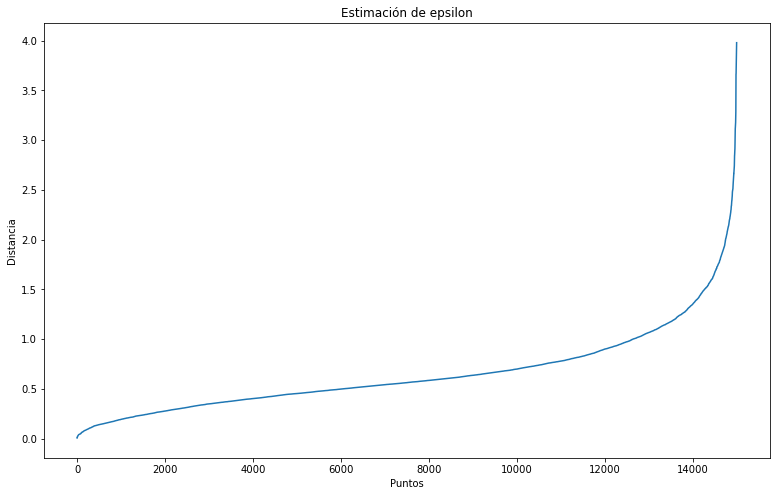

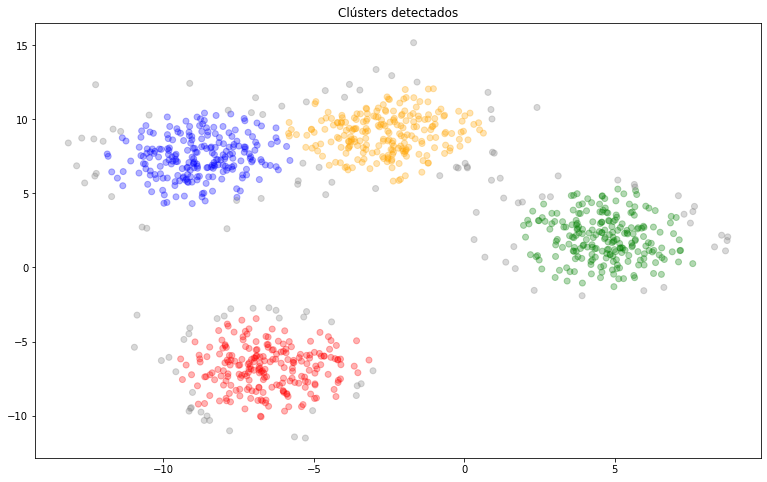

In [15]:
# Epsilón adecuado
elbow_dbscan(X, 15)

# Cálculo
modelo_dbscan_blobs = cluster.DBSCAN(eps=1, min_samples=15)
modelo_dbscan_blobs.fit(X)

# Visualización
clusters_view(X, modelo_dbscan_blobs.labels_)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

En este caso vemos que sí que detecta bien los clústers al igual que antes, con la diferencia de que ahora los clústers se calculan a partir de la densidad y no de la distancia. Con eps indicamos el radio de vecindad de un punto, y con min_samples definimos la cantidad mínima de vecinos que hay dentro del radio de vecindad para considerar el punto dentro del clúster.

Cabe destacar que ahora no todos los puntos pertenecen a un clúster en sí, es decir, hay puntos grises que no forman parte de ningún clúster, en otras palabras tenemos outliers. Estos puntos se caracterizan porque no cumplen tanto la distancia como el número mínimo de vecinos en dicha distancia, por lo tanto, ahora a diferencia de kmeans podemos ver que no todos los puntos deberían pertenecer a un clúster, ya que no presentan las mismas similitudes.

In [16]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de DBScan jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Moons.
</div>

En este caso se ha dictaminado que min_samples sea 5 ya que era lo que mejor funcionaba para nuestro modelo (jugando con diferentes valor de min_samples), y a prtir de min_samples obtenemos una estimación del epsilon a utilizar.

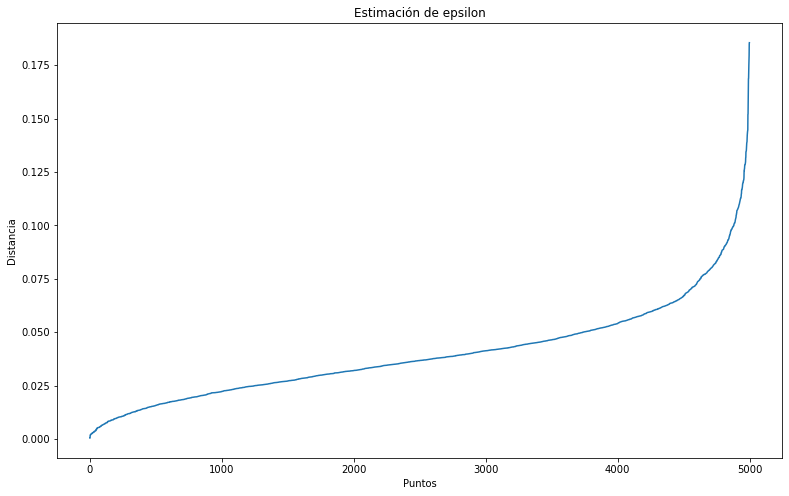

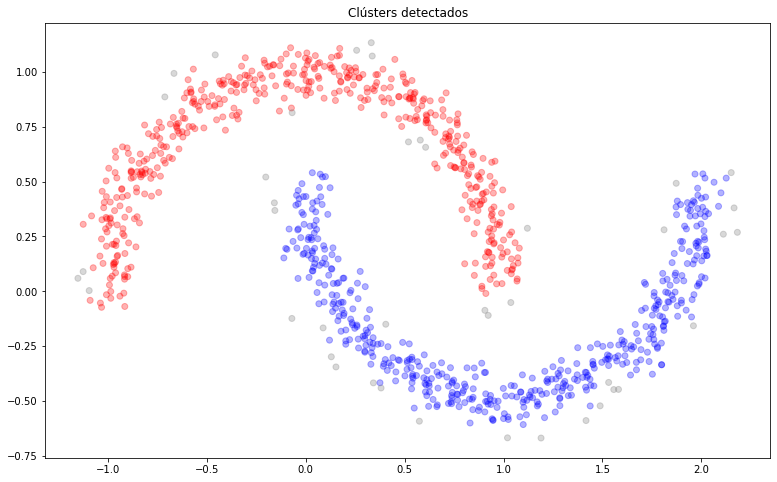

In [17]:
# Epsilón adecuado
elbow_dbscan(X, 5)

# Cálculo
modelo_dbscan_moons = cluster.DBSCAN(eps=0.075, min_samples=5)
modelo_dbscan_moons.fit(X)

# Visualización
clusters_view(X, modelo_dbscan_moons.labels_)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

A diferencia de kmeans, DBSCAN al basarse en la densidad y no en la distancia en sí, conseguimos que en este caso, es decir, cuando los clústers no son convexos, identifique bien los grupos. Aún así vemos que se sigue habiendo outliers, hay pequeños puntos que no cumplen con el número de vecinos mínimos dentro del radio establecido.

En resumen, al ir calculado para cada punto si dentro del radio epsilon hay un número de vecinos mínimos, conseguimos que se identifiquen bien los clústers, ya que no se tiene en cuenta la distancia en sí de cada punto al centroide como sucede con kmeans, ya que en ese caso el centroide es difícil de establecer.

In [18]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de DBScan jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Circles.
</div>

Se ha utilizado un min_samples de 10 porque tras probar diferentes valores era lo que mejor funcionaba, y partir de ese valor se estima el valor de epsilon.

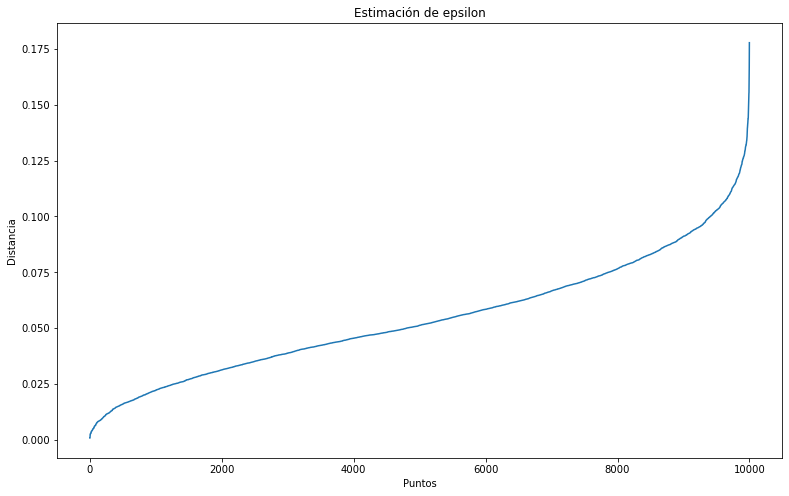

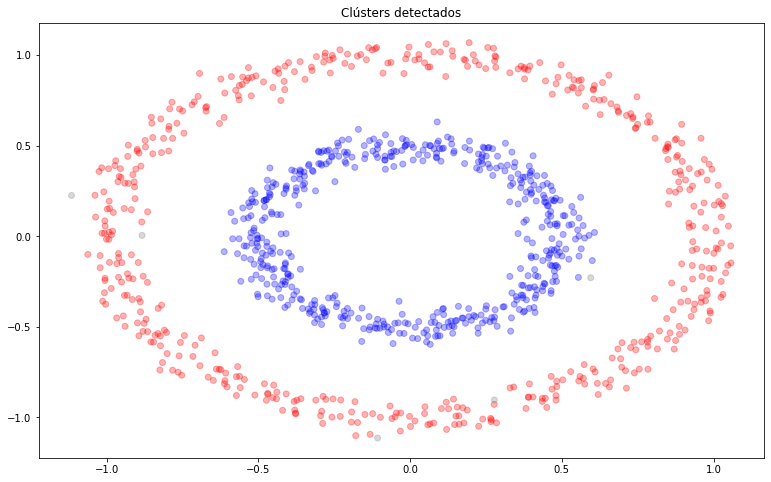

In [19]:
# Epsilón adecuado
elbow_dbscan(X, 10)

# Cálculo
modelo_dbscan_circles = cluster.DBSCAN(eps=0.1, min_samples=10)
modelo_dbscan_circles.fit(X)

# Visualización
clusters_view(X, modelo_dbscan_circles.labels_)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

En este caso sucede lo mismo que en el ejercicio anterior, DBSCAN sí que es capaz de identificar bien los clústers ya que se basa en la densidad, es decir, no calcula la distancia entre un punto al centroide del clúster, sino que usa el radio (epsilon) y el número de vecinos mínimo (min_samples) para añadir un punto a un clúster.

Cabe destacar que en este caso también tenemos algunos outliers, pero son muy pocos. En resumen, DBSCAN consigue identificar de forma correcta los clústers.

### 1 c. Algoritmos jerárquicos

En este apartado se pide visualizar mediante un [dendrograma](https://en.wikipedia.org/wiki/Dendrogram) la construcción progresiva de los grupos mediante un algoritmo jerárquico aglomerativo (estrategia *bottom-up*). Con ello se pretende encontrar un método gráfico para entender el comportamiento del algoritmo y encontrar los *clusters* deseados en cada dataset.

In [20]:
X, y = X_blobs, y_blobs

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Blobs.<br>
Puedes importar las librerías necesarias para ello.
</div>

In [21]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

def dendrograma(X, method):
    plt.figure(figsize=(13, 8))
    plt.title("Dendrograma según " + method)
    sch.dendrogram(sch.linkage(X, method = method))
    plt.show() 

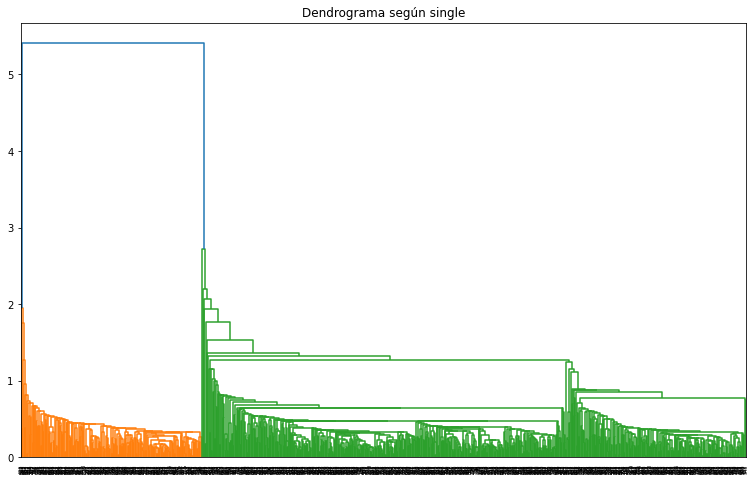

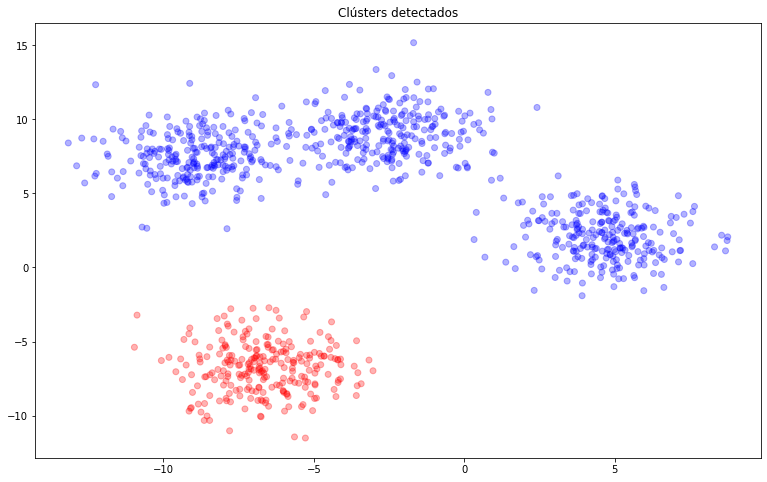

In [22]:
# Dendrograma
dendrograma(X, "single")

# Modelo
modelo_aglomerativo_blobs = AgglomerativeClustering(n_clusters=2,
                                                    affinity='euclidean',
                                                    linkage='single')
modelo_aglomerativo_blobs.fit_predict(X)

# Visualización
clusters_view(X, modelo_aglomerativo_blobs.labels_)

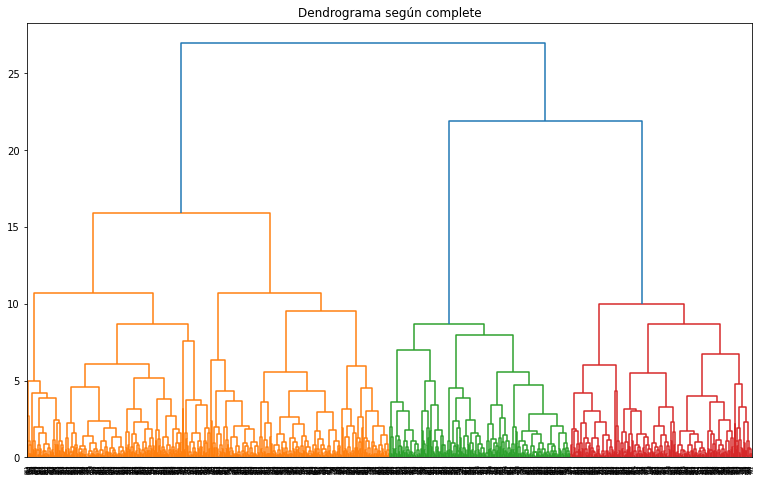

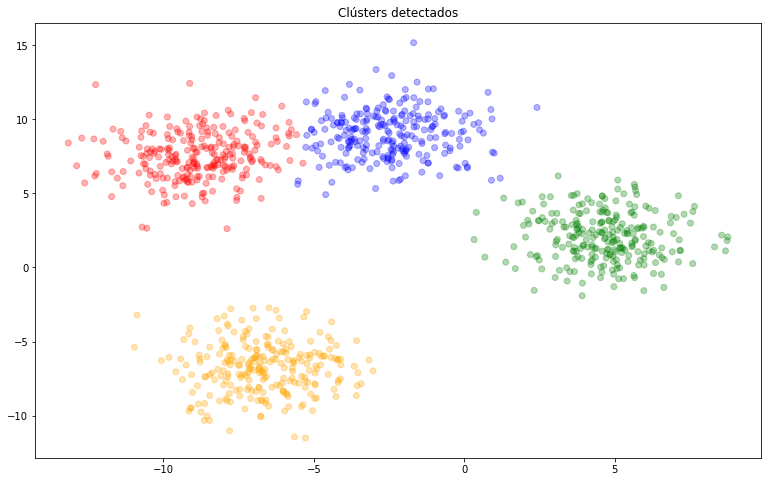

In [23]:
# Dendrograma
dendrograma(X, "complete")

# Modelo
modelo_aglomerativo_blobs = AgglomerativeClustering(n_clusters=4,
                                                    affinity='euclidean',
                                                    linkage='complete')
modelo_aglomerativo_blobs.fit_predict(X)

# Visualización
clusters_view(X, modelo_aglomerativo_blobs.labels_)

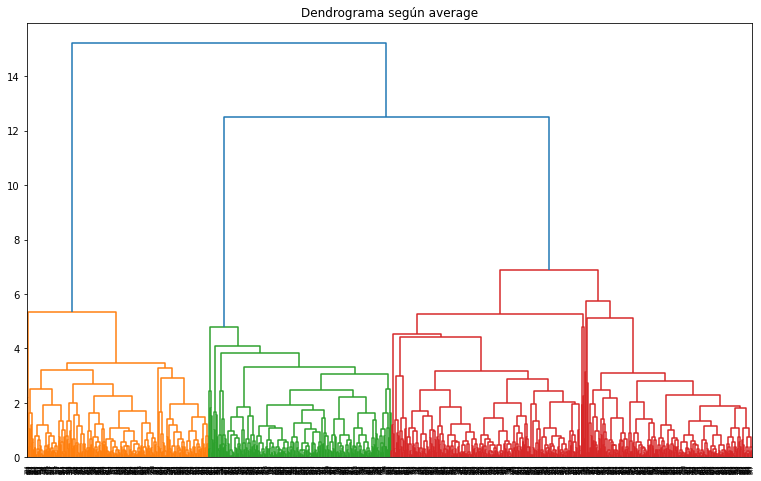

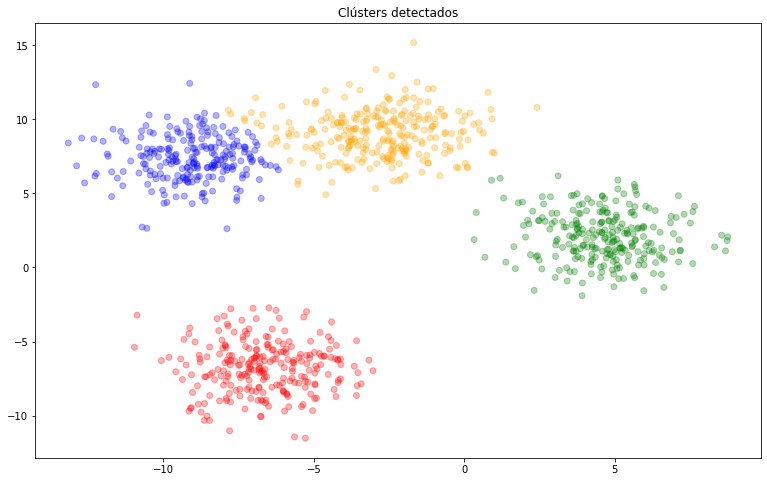

In [24]:
# Dendrograma
dendrograma(X, "average")

# Modelo
modelo_aglomerativo_blobs = AgglomerativeClustering(n_clusters=4,
                                                    affinity='euclidean',
                                                    linkage='average')
modelo_aglomerativo_blobs.fit_predict(X)

# Visualización
clusters_view(X, modelo_aglomerativo_blobs.labels_)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

Para la realización de este ejercicio se ha calculado con tres tipos de enlace:

- Enlace simple: usa la distancia mínima entre elementos. Como se puede apreciar tanto en el dendrograma y los clústers que nos proporiona por salida no es el enlace adecuado, según el dendrograma hay 2 clústers y la ejecución del algoritmo vemos que hay dos clústers también, es decir, se produce el problema de cadena, el cual consiste en la unión de grupos solamente por tener elementos muy próximos entre los mismos.

- Enlace completo: usa la distancia máxima entre elementos. En este caso tanto en el dendrograma como en al ejecución del algoritmo nos proporciona los cuatros clústers que estamos buscando. Este tipo de enlace consigue eliminar el efecto cadena pero es sensible a los outliers. Aún así este enlace puede ser bueno para este problema.

- Enlace medio: es una mezcla entre el enlace simple y completo trantando de mitigar los problemas del efecto cadena y outliers, tanto en el dendrograma como en la ejecución del algiritmo nos indica de forma clara que lo mejor son cuatro clústers, por lo que este tipo de enlace también pueder ser útil para resolver el problema.

Como nota aclaratoria, el número de clústers ideales según el dendrograma viene determinado por la línea vertical más alta sin ser cortada horizontalmente, de tal forma que en ese línea hacemos un corte horizontal a todo el árbol y nos indica el número de clústers ideales para aplicar el algoritmo aglomerativo.

En resumen, tanto el enlace completo como el enlace medio pueden ser usados de forma idónea para resolver este problema.

In [25]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Moons.<br>
Puedes importar las librerías necesarias para ello.
</div>

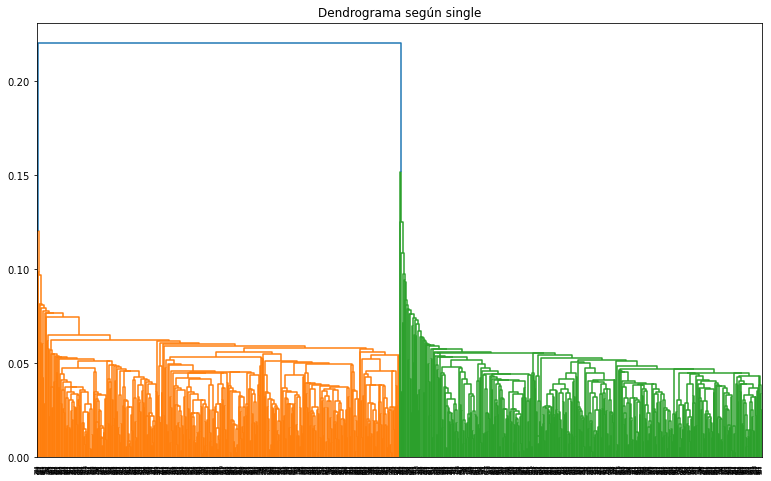

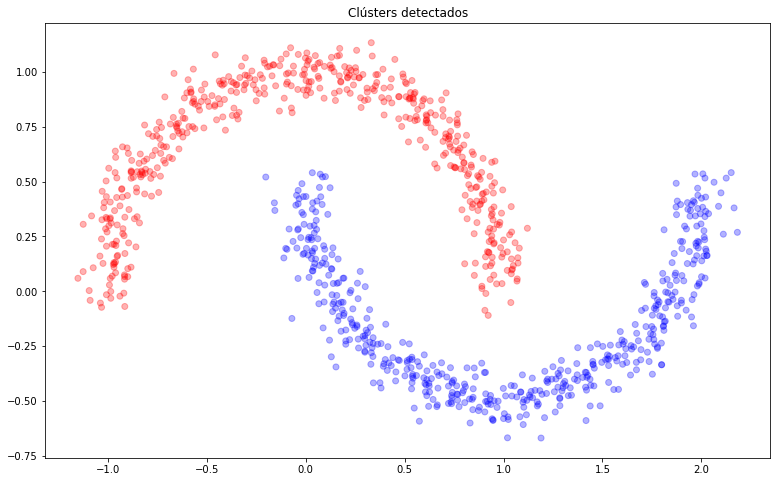

In [26]:
# Dendrograma
dendrograma(X, "single")

# Modelo
modelo_aglomerativo_moons = AgglomerativeClustering(n_clusters=2,
                                                    affinity='euclidean',
                                                    linkage='single')
modelo_aglomerativo_moons.fit_predict(X)

# Visualización
clusters_view(X, modelo_aglomerativo_moons.labels_)

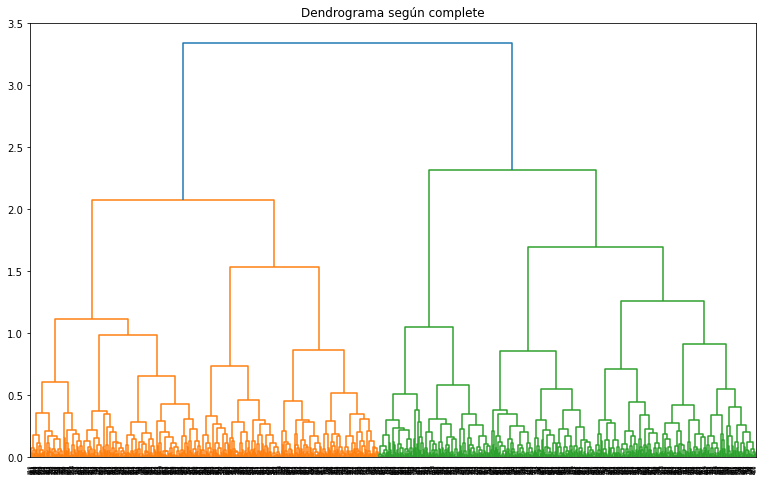

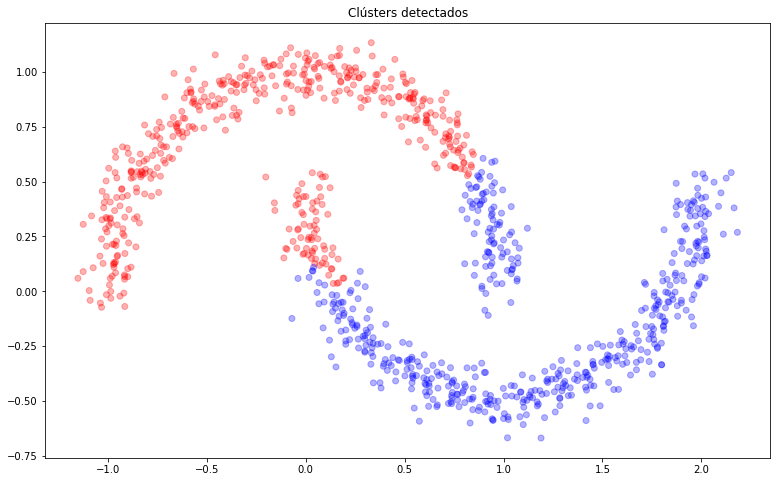

In [27]:
# Dendrograma
dendrograma(X, "complete")

# Modelo
modelo_aglomerativo_moons = AgglomerativeClustering(n_clusters=2,
                                                    affinity='euclidean',
                                                    linkage='complete')
modelo_aglomerativo_moons.fit_predict(X)

# Visualización
clusters_view(X, modelo_aglomerativo_moons.labels_)

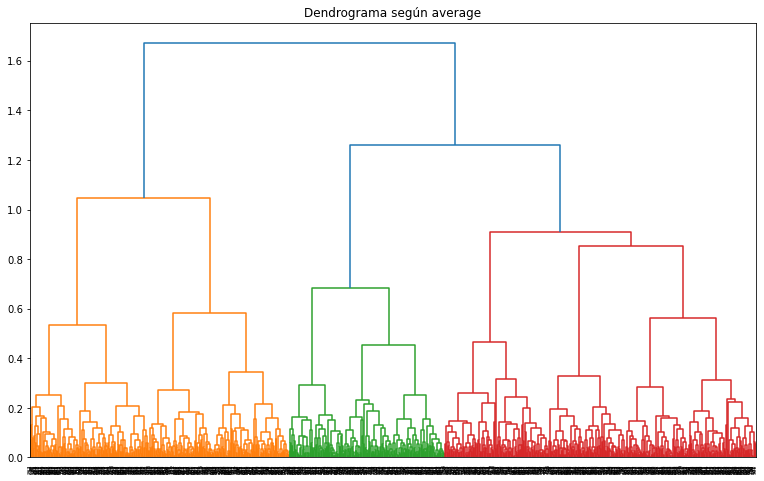

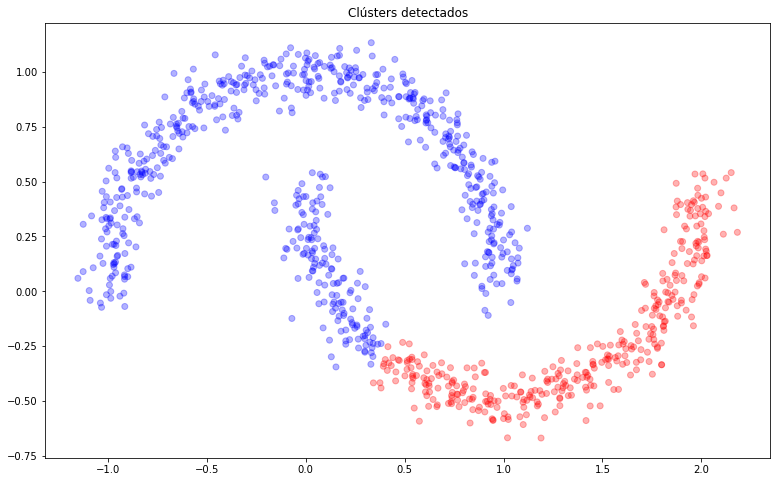

In [28]:
# Dendrograma
dendrograma(X, "average")

# Modelo
modelo_aglomerativo_moons = AgglomerativeClustering(n_clusters=2,
                                                    affinity='euclidean',
                                                    linkage='average')
modelo_aglomerativo_moons.fit_predict(X)

# Visualización
clusters_view(X, modelo_aglomerativo_moons.labels_)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

Para la realización de este ejercicio se han seguido usando los enlaces simple, completo y medio.

Respecto al enlace simple, vemos que en este caso el dendrograma nos indica de forma clara que dos clústers son lo ideal (porque la linea azul primera es la más grande y si partimos el diagrama horizontalmente por ahí nos quedan dos grupos). Al ejecutar el algoritmo con dos clústers vemos que realiza una perfecta clasificación, es decir, hay dos claros grupos diferenciados y al hacer uso de la distancia mínima entre elementos del grupo se consigue los clústers que estamos buscando, sin tener el efecto de cadena.

En cuanto al enlace completo, el dendrogrma nos indica que el número de clústers ideales pueden ser dos o cuatro, teniendo en cuenta la línea azul más a la izquierda tenemos 2 clústers, pero si nos fijamos en la línea verde más a la izquierda tendríamos 4 clústers. Como sabemos que lo ideal son dos, al ejecutar el algoritmo vemos que no consigue identificar bien los clústers, debido a que calcula la distancia máxima entre elementos.

Respecto al enlace medio, el dendrograma indica que el número ideal es 2 clústers y al ejecutar el algoritmo vemos que tampoco consigue obtener los clústers que buscamos.

En resumen, para este problema el enlace que mejor funciona es el enlace simple, ya que tiene en cuenta la distancia mínima entre elementos.

In [29]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Circles.<br>
Puedes importar las librerías necesarias para ello.
</div>

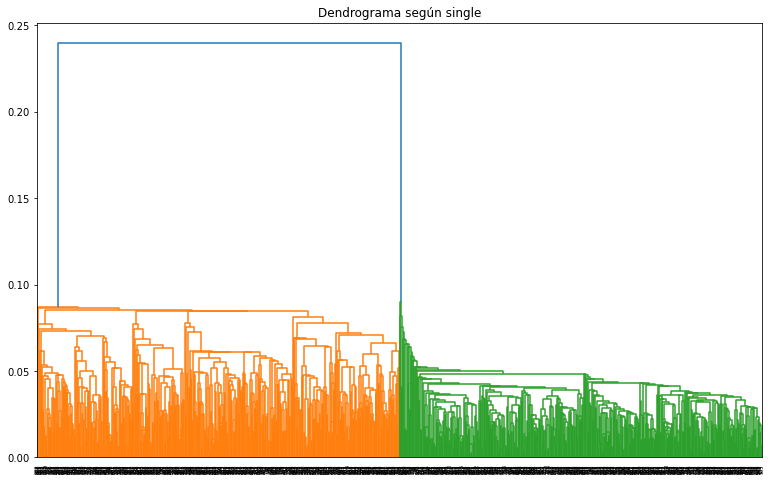

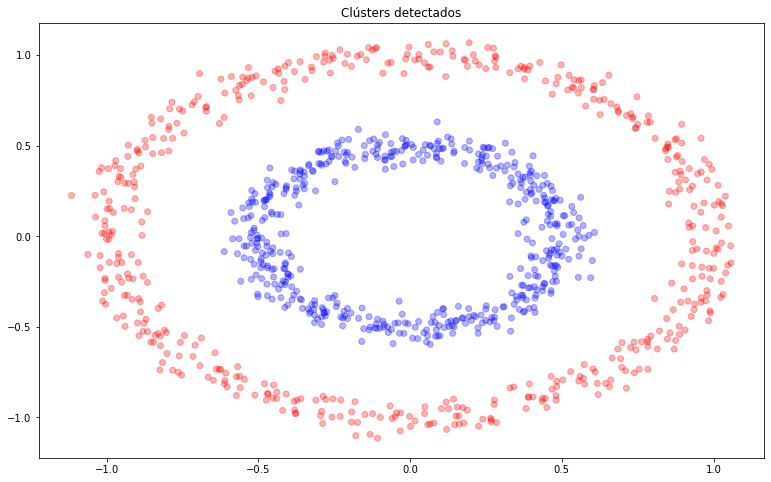

In [30]:
# Dendrograma
dendrograma(X, "single")

# Modelo
modelo_aglomerativo_circles = AgglomerativeClustering(n_clusters=2,
                                                    affinity='euclidean',
                                                    linkage='single')
modelo_aglomerativo_circles.fit_predict(X)

# Visualización
clusters_view(X, modelo_aglomerativo_circles.labels_)

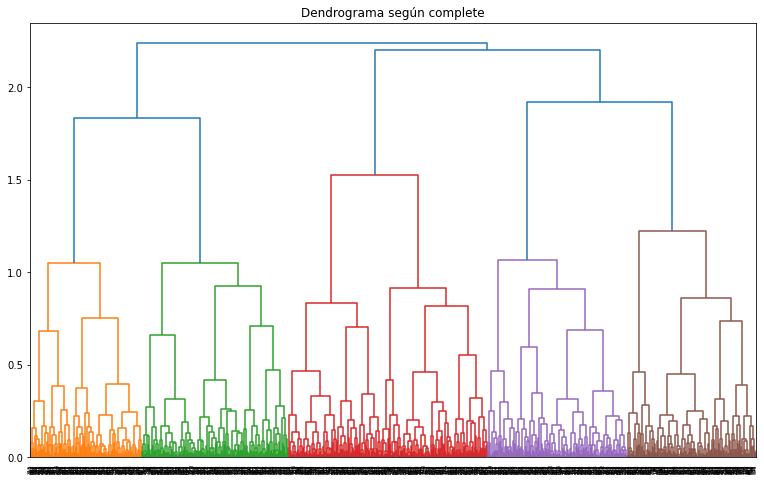

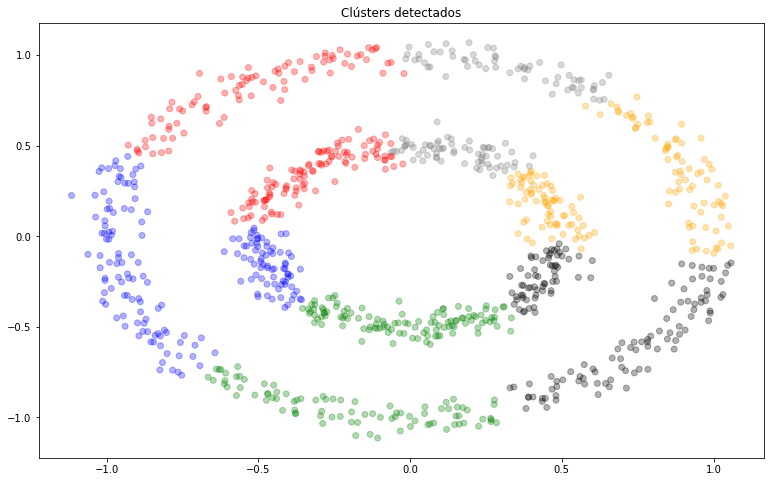

In [31]:
# Dendrograma
dendrograma(X, "complete")

# Modelo
modelo_aglomerativo_circles = AgglomerativeClustering(n_clusters=6,
                                                    affinity='euclidean',
                                                    linkage='complete')
modelo_aglomerativo_circles.fit_predict(X)

# Visualización
clusters_view(X, modelo_aglomerativo_circles.labels_)

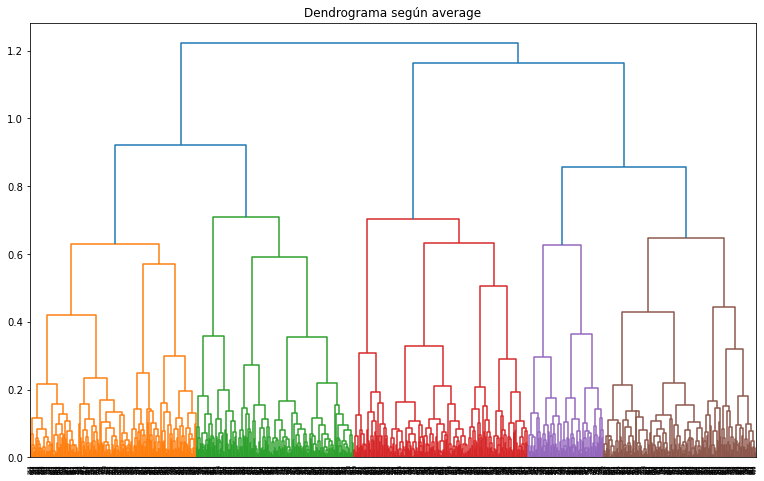

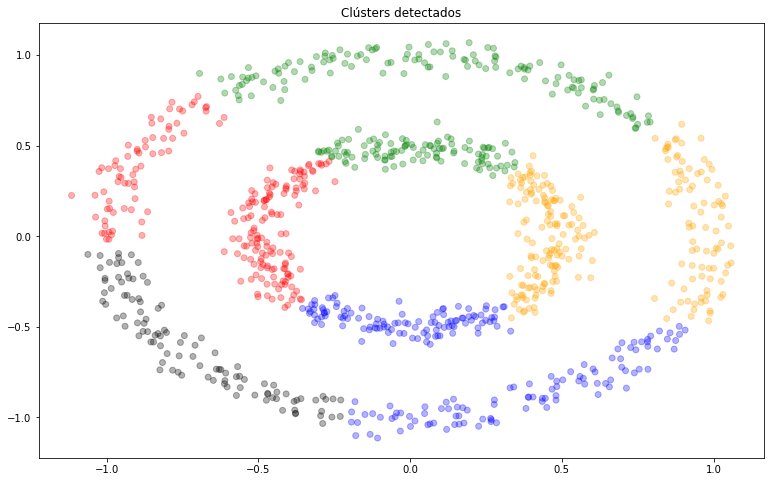

In [32]:
# Dendrograma
dendrograma(X, "average")

# Modelo
modelo_aglomerativo_circles = AgglomerativeClustering(n_clusters=5,
                                                    affinity='euclidean',
                                                    linkage='average')
modelo_aglomerativo_circles.fit_predict(X)

# Visualización
clusters_view(X, modelo_aglomerativo_circles.labels_)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

Como era de esperar, este problema es similar al anterior por lo que el enlace que mejor funciona es el simple, básicamente porque tiene en cuenta la distancia mínima entre los elementos del grupo y como los clústers están bien diferenciados no se produce el efecto cadena. El dendograma de este enlace nos indica que el mejor número de clústers es 2, es decir, los clústers que estamos buscando.

En cuanto al enlace completo y enlace medio no son idóneos para este tipo de problemas, el primer enlace nos indica que el número de clústers tiene que ser 6 (hay que cortar por la penúltima línea vertical azul), y el segundo enlace nos indica que tiene que ser 5 grupos (hay que cortar por la tercera línea azul). Por lo tanto, los dendrogramas de estos enlaces nos están indicando que no son buenos enlaces para nuestro problema, ya que nos indican que lo ideal son 5 y 6 grupos cuando realmente son 2.

<a id="ej2"></a>

## 2. Aplicación: generación de imágenes con reducción de dimensionalidad (3 puntos)

Es posible aplicar una amplia variedad de algoritmos para la reducción de dimensionalidad. Para ello se empleará el dataset MNIST compuesto de miles de dígitos manuscritos del 0 al 9. Donde cada imagen se compone de 784 píxeles (imágenes de 28 x 28), por lo que se parte de un número alto de dimensiones.

In [33]:
X, y = sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

Por lo que cada muestra (las 70k filas del dataset) se componen de 784 dimensiones:

In [34]:
X.shape

(70000, 784)

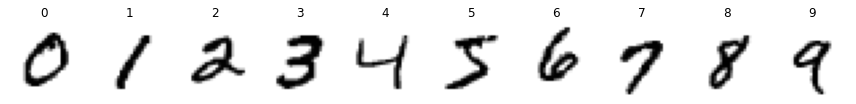

In [35]:
fig, axis = plt.subplots(1, 10, figsize=(12, 6))
for i, ax in enumerate(axis):
    ax.imshow(X[y == str(i)][0].reshape(28, 28), cmap='gray_r')
    ax.set_title(str(i))
    ax.axis('off')
plt.tight_layout()

Si cada algoritmo obtiene resultados distintos a la hora de reducir la dimensionalidad, ¿qué representación es más fiel a la distribución original?

Antes de reducir las 784 dimensiones originales de cada muestra a 2 para poder visualizarlas en 2 dimensiones, es muy útil conocer, o al menos intuir, la estructura en alta dimensionalidad de los datos.

Para ello se puede hacer uso del dendrograma como heurística para conocer la disposición original de los datos y comprobar si la proyección es similar a lo mostrado por el dendrograma.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> aprender una proyección a 2 dimensiones de las muestras de X con <a href="https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html">PCA</a> y proyectar el conjunto X a dos dimensiones. Después visualizarlo en un scatter plot.

Utiliza las etiquetas de y (el número manuscrito al que se corresponde cada muestra), en el parámetro label (en la llamada a scatter) y la función legend en la visualización para saber la clase correspondiente a cada punto e interpretar el resultado de la reducción de dimensionalidad y poder interpretar el resultado de la proyección.
</div>

Text(0, 0.5, 'Segundo componente principal')

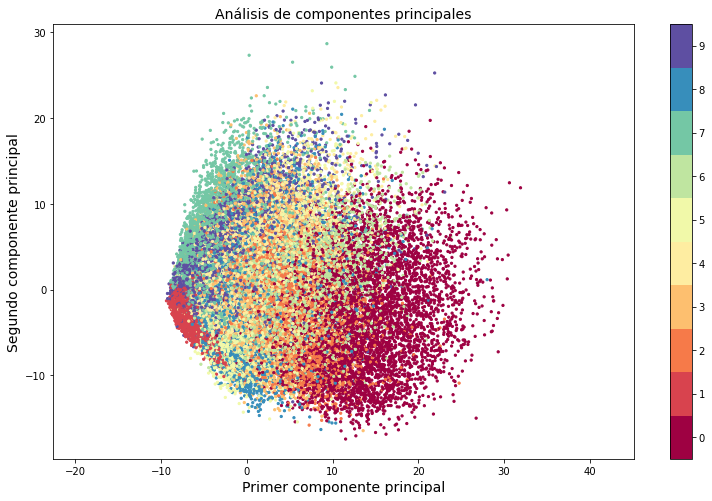

In [85]:
from sklearn.preprocessing import StandardScaler

# Normilizar el dataset
X_normalizado = StandardScaler().fit_transform(X)

# Creación del PCA
modelo_pca = decomposition.PCA(n_components=2)
X_pca = modelo_pca.fit_transform(X_normalizado)

# Visualización
# https://www.kaggle.com/parulpandey/part1-visualizing-kannada-mnist-with-pca
y_numerico = [int(i) for i in y] # Convertimos a número las etiquetas

plt.figure(figsize=(13,8), facecolor="white")
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=5, c=y_numerico, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('Análisis de componentes principales', fontsize=14)
plt.xlabel('Primer componente principal', fontsize=14)
plt.ylabel('Segundo componente principal', fontsize=14)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué puedes interpretar de la proyección? ¿Las clases han quedado visiblemente separadas? ¿Por qué?
</div>

Lo primero de todo, las clases no han quedado visiblemente separadas, es decir, sí que se pueden apreciar patrones gracias a los colores, pero están todos los puntos juntos y es difícil de diferenciar en la parte central de la representación.

Uno de los motivos por los que no queda del todo bien diferenciadas las clases puede ser porque estamos reduciendo las dimensiones originales (784) a dos dimensiones, es decir, el modelo no es capaz de representar toda la variabilidad del mismo ya que hay mucha diferencia entre las dimensiones originales a dos dimensiones (se pierde información). Ésto se podría solventar haciendo un estudio de cuántas dimensiones son ideales para este problema, y a partir de ahí generar el modelo con dichas dimensiones.

Aunque se ha comentado que es difícil de interpretar en profundiad la representación, sí que podemos ver patrones en los datos. Por ejemplo, vemos que el número 0 (rojo oscuro) y el número 7 (verde azulado) están opuestos el uno del otro, esto tiene toda la lógica del mundo y es que los píxeles usados para representar ambos son muy diferentes. Otro caso sería el del 8 (azul oscuro) junto con el 0 y el 7, es decir, el ocho usa píxeles muy parecidos al número 0 por lo que ambos están más juntos en la representación que respecto al número 7. También vemos que en el medio de la representación hay muchos números que usan píxeles parecidos, como el 4, el 5, el 6.

En resumen, aunque las clases no quedan del todo definidas sí que lo hacen de forma suficiente como para poder detectar patrones en los datos.

En la gráfica anterior cada punto representa una muestra en 2 dimensiones. Con PCA es posible <a href="https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.inverse_transform">invertir la transformación</a> para que, a partir de cada punto 2d, se obtenga de nuevo (aproximadamente) la imagen original (784 dimensiones).

Por lo que es posible "generar" nuevas imágenes eligiendo puntos aleatoriamente del plano 2d, y pedirle al modelo PCA aprendido que invierta la transformación para obtener las "teóricas" imágenes que habrían sido proyectadas a esos puntos del espacio proyectado.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> calcular el máximo y mínimo de cada una de las dos dimensiones y, para cada una de ellas, <a href="https://numpy.org/doc/stable/reference/generated/numpy.linspace.html">generar una secuencia</a> de 10 valores con igual separación.
</div>

Con las dos secuencias de 10 (una por cada dimensión del plano de proyección) valores es posible combinar los puntos de ambas secuencias para generar 100 combinaciones (puntos 2d) que teselan el plano sobre el que PCA ha proyectado las muestras.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> invertir la transformación para cada uno de los 100 puntos y visualizar su imagen asociada en una matriz de 10 x 10 imágenes (tratando de preservar su posición en el espacio proyectado).
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué puedes interpretar de las imágenes reconstruidas / interpoladas? ¿Genera números o transiciones entre números visualmente creíbles? ¿Por qué?
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Podría haberse conseguido lo mismo con <a href="https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html">t-SNE</a>? ¿Por qué?
</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> aprender una proyección a 2 dimensiones de las muestras de X con <a href="https://towardsdatascience.com/how-exactly-umap-works-13e3040e1668">UMAP</a> (con los parámetros por defecto) usando la librería <a href="https://umap-learn.readthedocs.io/en/latest/">umap-learn</a> y proyectar el conjunto X a dos dimensiones. Después visualizarlo en un scatter plot.

Utiliza las etiquetas de y (el número manuscrito al que se corresponde cada muestra), en el parámetro label (en la llamada a scatter) y la función legend en la visualización para saber la clase correspondiente a cada punto e interpretar el resultado de la reducción de dimensionalidad y poder interpretar el resultado de la proyección.
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué puedes interpretar de la proyección? ¿Las clases han quedado visiblemente separadas? ¿Por qué?
</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> al igual que anteriormente con PCA, calcula el máximo y mínimo para cada una de las dos dimensiones e invierte la transformación con el modelo aprendido por UMAP para cada uno de los 100 puntos y visualizar su imagen asociada en una matriz de 10 x 10 imágenes (tratando de preservar su posición en el espacio proyectado).
    
<strong>Consejo</strong>: la inversión de la transformación en UMAP es más costosa computacionalmente que con PCA, por lo que recomiendo que sólo la invoques una vez con las 100 muestras en lugar de hacer 100 llamadas (una por cada muestra). Esto reduce drácticamente el tiempo de ejecución.
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué puedes interpretar de las imágenes reconstruidas / interpoladas? ¿Genera números o transiciones entre números visualmente creíbles? ¿Por qué?
</div>

<a id="ej3"></a>

## 3. Aplicación: identificación de puntos de interés turísticos (3 puntos)

En este ejercicio se busca automatizar la localización de lugares turísticos a través de los metadatos de las fotografías de flickr.

Para ello se provee junto a la PEC el dataset: ``barcelona.csv``. Ya que se pide encontrar los puntos de mayor interés turístico de esta ciudad.

**Opcional: si quieres hacerlo para otra región**

Pero si quieres hacerlo para otra parte del mundo, puedes descargarte el dataset completo [aquí](https://drive.google.com/file/d/0B-mRR4rjwHPONVFfX2VmTmxZcHM/view?usp=sharing) y descomprime para extraer el *CSV*.

Para seleccionar las coordenadas de la zona de interés puedes usar la opción *Export* manual de [OpenStreetMaps](https://www.openstreetmap.org/).

Por último, para filtrar los datos que se corresponden a la zona deseada puedes usar el programa *AWK* mediante la siguiente línea:

``awk -F"," 'NR == 1 {print $5","$6} (NR > 1 && $5 > 41.3560 && $5 < 41.4267 && $6 > 2.1300 && $6 < 2.2319) {print $5","$6}' photo_metadata.csv``

``$5`` hace referencia a la latitud, y ``$6`` a la longitud. Sustituye los valores mínimo y máximo para obtener los datos de localización referentes a tu área de interés.

In [ ]:
geo_df = pd.read_csv('barcelona.csv', header=0)
geo_df.sample(5)

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> siempre que tratamos un problema real, es necesario entender los datos a tratar. Visualiza las localizaciones de las fotografías mediante un scatter plot. Prueba distintos parámetros de tamaño (<i>size</i>) <i>s</i>, y opacidad <i>alpha</i> hasta conseguir un resultado fácil de interpretar. 
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> tras haber probado los algoritmos de agrupamiento en el ejercicio 1. ¿Qué algoritmo crees que sería más adecuado tras visualizar los datos? ¿Por qué?
</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> para prototipar el modelado primero se recomienda elegir un subconjunto de los datos que sea representativo. Selecciona una muestra del DataFrame original y visualiza como en el punto anterior para comprobar su similitud. 
</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> ajusta el algoritmo de clustering elegido para encontrar los distintos grupos sobre el conjunto reducido, y visualiza el resultado coloreando cada punto en base al grupo al que pertenece. Como pista, alrededor de 20 clusters es un número razonable, y es posible darles un color distinto a cada uno con el <i>colormap: tab20</i>.
</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> si has usado un método de <i>clustering</i> que permite la detección de <i>outliers</i>. Representa sólo los puntos que no ha considerado <i>outliers</i>, es decir, los que pertenecen a algún <i>cluster</i>.
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> interpreta cual es el lugar que representa cada <i>cluster</i> (si encuentras una asociación lógica).
</div>

<div class="alert alert-block alert-info">
<strong>OPCIONAL Implementación:</strong> representa los puntos sin ruido sobre un mapa utilizando la librería <a href="https://pypi.org/project/smopy/">Smopy</a>. Para facilitar la interpretación, puedes representar cada cluster como el punto medio de todos los puntos que lo conforman.
</div>